# FragGPT, utilizing GPT for File Fragment Identification

### Download Libraries

In [24]:
!pip install openai scikit-learn pandas numpy matplotlib torch torchvision scipy seaborn kagglehub

### Import Necessary Libraries

In [25]:
import openai
import os 
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


### Project Objective & Reproducibility
This notebook classifies **file fragments** into image file types. We model fragments as **1D byte sequences** (not images).  
We'll ensure reproducibility and a clean environment setup.

**Plan**
- Dataset: custom `FragmentBinaryDataset` that loads `.dat` fragments as 1D byte tensors (0–255 → 0–1).
- Model: 1D CNN for sequence patterns.
- Training: standard cross-entropy with accuracy/F1.
- GPT (optional): aggregate multiple sub-slice predictions for comparison.

**Seeds**
We set seeds for Python, NumPy, and PyTorch.


In [26]:

# Reproducibility: set seeds for python, numpy, and torch
import os, random, numpy as np, torch
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print("Seeds set.")


Seeds set.


### Define DataLoaders

In [27]:

import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import numpy as np

class FragmentBinaryDataset(Dataset):
    """Loads binary .dat fragments as 1D byte tensors.
    - root_dir: directory with class subfolders or loose .dat files
    - fragment_len: number of bytes per sample (truncate or pad with zeros)
    """
    def __init__(self, root_dir, fragment_len=1024, classes=None):
        self.root_dir = Path(root_dir)
        self.fragment_len = fragment_len
        # infer classes from subdirectories if not provided
        if classes is None:
            if any(p.is_dir() for p in self.root_dir.iterdir()):
                self.classes = sorted([p.name for p in self.root_dir.iterdir() if p.is_dir()])
                self.samples = []
                for ci, cname in enumerate(self.classes):
                    for f in sorted((self.root_dir / cname).glob("*.dat")):
                        self.samples.append((f, ci))
            else:
                # flat folder; class is unknown => use 0
                self.classes = ["unknown"]
                self.samples = [(f, 0) for f in sorted(self.root_dir.glob("*.dat"))]
        else:
            self.classes = classes
            self.samples = []
            for ci, cname in enumerate(self.classes):
                for f in sorted((self.root_dir / cname).glob("*.dat")):
                    self.samples.append((f, ci))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            with open(path, "rb") as fh:
                data = fh.read(self.fragment_len)
            # pad if shorter
            if len(data) < self.fragment_len:
                data = data + b"\x00" * (self.fragment_len - len(data))
            # convert to float tensor in [0,1], shape (1, L) for Conv1d
            arr = np.frombuffer(data[:self.fragment_len], dtype=np.uint8).astype(np.float32) / 255.0
            tensor = torch.from_numpy(arr).unsqueeze(0)  # (1, L)
        except Exception as e:
            # fallback: zero tensor if corrupted; could also raise
            tensor = torch.zeros(1, self.fragment_len, dtype=torch.float32)
        return tensor, label, str(path)


### Module Architecture

In [28]:

import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_dim=1, num_classes=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.net(x)        # (B, 256, 1)
        logits = self.head(x)  # (B, C)
        return logits

# Instantiate with inferred classes later


### Training and Testing Data Loaders

In [29]:

# Data loaders (no image transforms; bytes are 1D sequences)
from torch.utils.data import DataLoader

train_root = "../Fragments/Training"
test_root  = "../Fragments/Testing"

# Infer classes from train_root subfolders
train_ds = FragmentBinaryDataset(train_root, fragment_len=1024)
classes = train_ds.classes
test_ds  = FragmentBinaryDataset(test_root, fragment_len=1024, classes=classes)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print(f"Classes: {classes}")
print(f"Train: {len(train_ds)} samples | Test: {len(test_ds)} samples")


Classes: ['Legacy', 'Modern']
Train: 24 samples | Test: 7 samples



### GPT Aggregated Inference 
We sample multiple sub-slices per fragment, prompt GPT to guess the class, and **aggregate** votes.
For compactness, we Base64-encode the sub-slice.


In [30]:
# Configure your OpenAI API key via environment variable OPENAI_API_KEY\nfrom openai import OpenAI\nclient = OpenAI()\nprint('OpenAI client ready (set OPENAI_API_KEY in env).')

In [ ]:
import base64, json, random

# Map class names to labels for prompting
class_to_label = {c:i for i, c in enumerate(classes)}
label_to_class = {i:c for c,i in zip(classes, range(len(classes)))}

def gpt_guess_for_bytes(b):
    """Return a predicted class name from GPT given raw bytes b (<= 256 bytes)."""
    b64 = base64.b64encode(b).decode('ascii')
    system = "You are a forensics assistant. You classify small byte fragments into file types."
    user = f"""Given this Base64-encoded byte fragment, predict the file type from {classes}.
Fragment (Base64): {b64}
Return ONLY the class name."""
    try:
        # NOTE: User must have API key configured in environment for this to work.
        from openai import OpenAI
        client = OpenAI()
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role":"system","content":system},
                      {"role":"user","content":user}],
            temperature=0
        )
        text = resp.choices[0].message.content.strip()
        # normalize to known class if possible
        for c in classes:
            if c.lower() in text.lower():
                return c
        return text  # fallback raw
    except Exception as e:
        return "ERROR"

def gpt_vote_for_fragment(tensor_bytes, samples=5, sub_len=256):
    votes = []
    raw = (tensor_bytes * 255.0).clamp(0,1).squeeze(0).to(torch.uint8).cpu().numpy().tobytes()
    L = len(raw)
    for _ in range(samples):
        if L <= sub_len:
            start = 0
        else:
            start = random.randint(0, L - sub_len)
        chunk = raw[start:start+sub_len]
        pred = gpt_guess_for_bytes(chunk)
        votes.append(pred)
    # majority
    if not votes:
        return "UNKNOWN"
    best = max(set(votes), key=votes.count)
    return best, votes


### Define Prediction Function

In [32]:
def predict_fn(byte_tensor):
    # For demo: convert bytes to hex string (shortened). You can design a smarter encoding later.
    hex_repr = byte_tensor[:64].tolist()  # first 64 bytes as list of ints
    
    prompt = f"""
    You are a classifier that predicts whether a file fragment belongs to a Legacy or Modern image format.
    Legacy formats: BMP, GIF, JPEG, PNG, TIF
    Modern formats: WEBP, BPG, JXR, JPF
    
    Input fragment (first 64 bytes as ints): {hex_repr}
    
    Respond ONLY as a JSON object with probabilities that sum to 1. For example:
    {{
        "Legacy": 0.73,
        "Modern": 0.27
    }}
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",  # or other GPT model
        messages=[{"role": "user", "content": prompt}],
        temperature=0  # deterministic output
    )

    text = response.choices[0].message.content.strip()
    import json
    probs = json.loads(text)
    return probs["Modern"]  # probability for class 1

### Define Training Function and Evaluation Metrics 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import torch, time
import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(classes)
model = CNN(input_dim=1, num_classes=num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

import torch, random

def train_one_epoch(
    model, loader,
    *, use_ai=False, ai_weight=0.2,
    ai_sample_prob=0.25, ai_max_calls_per_batch=8,
    ai_fn=None, ai_cache=None
):
    """
    Train for one epoch.
    If use_ai=True, blends supervised loss with a soft-target loss from an AI teacher (e.g., predict_fn).
    - ai_weight:      weight of the AI (teacher) loss in [0,1]
    - ai_sample_prob: probability of querying the teacher for a given sample in a batch
    - ai_max_calls_per_batch: cap on teacher calls per batch (controls cost/latency)
    - ai_fn:          callable(tensor_1d) -> float in [0,1] giving P(Modern). Defaults to predict_fn.
    - ai_cache:       dict for memoizing teacher outputs keyed by first-64-byte signature
    """
    model.train()
    if ai_cache is None:
        ai_cache = {}

    losses, preds_all, labels_all = [], [], []

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(x)                   # [B, C]
        loss = criterion(logits, y)         # supervised CE

        # --- Optional AI teacher loss (binary Legacy vs Modern only) ---
        if use_ai and logits.size(1) == 2:
            # choose which samples to query this batch
            bsz = x.size(0)
            idxs = [i for i in range(bsz) if random.random() < ai_sample_prob]
            if ai_max_calls_per_batch is not None and len(idxs) > ai_max_calls_per_batch:
                idxs = random.sample(idxs, ai_max_calls_per_batch)

            # gather teacher probabilities
            teacher_probs_list = []
            student_logits_list = []

            for i in idxs:
                # create a compact cache key from first 64 bytes (post-flatten, uint8)
                xi = x[i].detach().flatten().cpu()
                sig = tuple(xi[:64].to(torch.uint8).tolist())

                if sig in ai_cache:
                    p_modern = ai_cache[sig]
                else:
                    try:
                        # default to your predict_fn if no ai_fn provided
                        fn = ai_fn if ai_fn is not None else predict_fn
                        p_modern = float(fn(xi))  # expect P(Modern) in [0,1]
                        p_modern = max(0.0, min(1.0, p_modern))
                        ai_cache[sig] = p_modern
                    except Exception:
                        p_modern = None  # skip if teacher unavailable/errored

                if p_modern is None:
                    continue

                # build soft target [P(Legacy), P(Modern)]
                t = torch.tensor([1.0 - p_modern, p_modern], device=device)
                teacher_probs_list.append(t.unsqueeze(0))
                student_logits_list.append(logits[i].unsqueeze(0))

            if teacher_probs_list:
                teacher_probs = torch.cat(teacher_probs_list, dim=0)           # [M, 2]
                student_logits = torch.cat(student_logits_list, dim=0)         # [M, 2]
                # Soft-target cross-entropy: -sum t * log softmax(s)
                kd_loss = -(teacher_probs * torch.log_softmax(student_logits, dim=1)).sum(dim=1).mean()
                loss = (1.0 - ai_weight) * loss + ai_weight * kd_loss

        # --- Backprop + metrics ---
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds = logits.argmax(dim=1)
        preds_all.extend(preds.detach().cpu().tolist())
        labels_all.extend(y.detach().cpu().tolist())

    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="macro")
    return float(sum(losses)/len(losses)), acc, f1


def evaluate(model, loader):
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            preds = logits.argmax(dim=1)
            preds_all.extend(preds.detach().cpu().tolist())
            labels_all.extend(y.detach().cpu().tolist())
    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="macro")
    cm = confusion_matrix(labels_all, preds_all)
    print("Classification Report:\n", classification_report(labels_all, preds_all, target_names=classes))
    return acc, f1, cm

def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(title)
    plt.savefig("results/matrix", dpi=300, bbox_inches="tight")

    plt.show()

## Evaluating Models (No GPT Inteference, GPT Inteference)

### No AI Integration

/home/daniel/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/home/daniel/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
               precision    recall  f1-score   support

      Legacy       1.00      0.33      0.50         3
      Modern       0.67      1.00      0.80         4

    accuracy                           0.71         7
   macro avg       0.83      0.67      0.65         7
weighted avg       0.81      0.71      0.67         7

Epoch 1/5 | loss=0.6781 acc=0.458 f1=0.457 | val_acc=0.714 val_f1=0.650 | 0.2s
✓ Saved best model -> best_cnn.pth


/home/daniel/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/daniel/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
               precision    recall  f1-score   support

      Legacy       1.00      0.33      0.50         3
      Modern       0.67      1.00      0.80         4

    accuracy                           0.71         7
   macro avg       0.83      0.67      0.65         7
weighted avg       0.81      0.71      0.67         7

Epoch 2/5 | loss=0.6858 acc=0.500 f1=0.500 | val_acc=0.714 val_f1=0.650 | 0.2s


/home/daniel/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/daniel/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
               precision    recall  f1-score   support

      Legacy       1.00      0.33      0.50         3
      Modern       0.67      1.00      0.80         4

    accuracy                           0.71         7
   macro avg       0.83      0.67      0.65         7
weighted avg       0.81      0.71      0.67         7

Epoch 3/5 | loss=0.6775 acc=0.500 f1=0.438 | val_acc=0.714 val_f1=0.650 | 0.2s


/home/daniel/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/daniel/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
               precision    recall  f1-score   support

      Legacy       1.00      0.33      0.50         3
      Modern       0.67      1.00      0.80         4

    accuracy                           0.71         7
   macro avg       0.83      0.67      0.65         7
weighted avg       0.81      0.71      0.67         7

Epoch 4/5 | loss=0.6696 acc=0.583 f1=0.496 | val_acc=0.714 val_f1=0.650 | 0.2s


/home/daniel/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/daniel/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
               precision    recall  f1-score   support

      Legacy       1.00      0.33      0.50         3
      Modern       0.67      1.00      0.80         4

    accuracy                           0.71         7
   macro avg       0.83      0.67      0.65         7
weighted avg       0.81      0.71      0.67         7

Epoch 5/5 | loss=0.6683 acc=0.583 f1=0.496 | val_acc=0.714 val_f1=0.650 | 0.2s


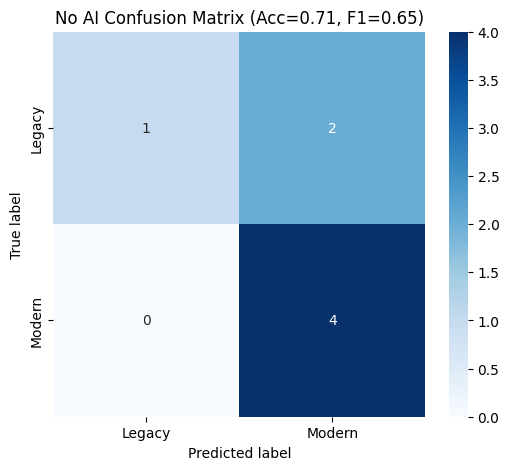

In [36]:
EPOCHS = 5  # Set number of epochs for training
best_acc = 0.0
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader)
    val_acc, val_f1, cm = evaluate(model, test_loader)
    dt = time.time() - t0
    print(f"Epoch {epoch}/{EPOCHS} | "
          f"loss={train_loss:.4f} acc={train_acc:.3f} f1={train_f1:.3f} | "
          f"val_acc={val_acc:.3f} val_f1={val_f1:.3f} | {dt:.1f}s")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model": model.state_dict(), "classes": classes}, "best_cnn.pth")
        print("✓ Saved best model -> best_cnn.pth")
plot_confusion_matrix(cm, classes, title=f"No AI Confusion Matrix (Acc={val_acc:.2f}, F1={val_f1:.2f})")


### AI Integration

In [ ]:
EPOCHS = 5  # Set number of epochs for training
best_acc = 0.0
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader,use_ai=True, ai_weight=0.3, ai_sample_prob=0.3, ai_max_calls_per_batch=8)
    val_acc, val_f1, cm = evaluate(model, test_loader)
    dt = time.time() - t0
    print(f"Epoch {epoch}/{EPOCHS} | "
          f"loss={train_loss:.4f} acc={train_acc:.3f} f1={train_f1:.3f} | "
          f"val_acc={val_acc:.3f} val_f1={val_f1:.3f} | {dt:.1f}s")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model": model.state_dict(), "classes": classes}, "best_cnn.pth")
        print("✓ Saved best model -> best_cnn.pth")
plot_confusion_matrix(cm, classes, title=f"AI Integration Confusion Matrix (Acc={val_acc:.2f}, F1={val_f1:.2f})")
